In [1]:
import sys
sys.path.insert(0, '../../')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from kernels.nn import ImplicitDenseNetKernel
from model.ick import ICK
from model.cmick import CMICK
from utils.train import CMICKEnsembleTrainer
from utils.helpers import *

# To make this notebook's output stable across runs
np.random.seed(2020)
torch.manual_seed(2020)
torch.cuda.manual_seed(2020)
torch.cuda.manual_seed_all(2020)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


# 1. Generate synthetic data for control and treatment groups

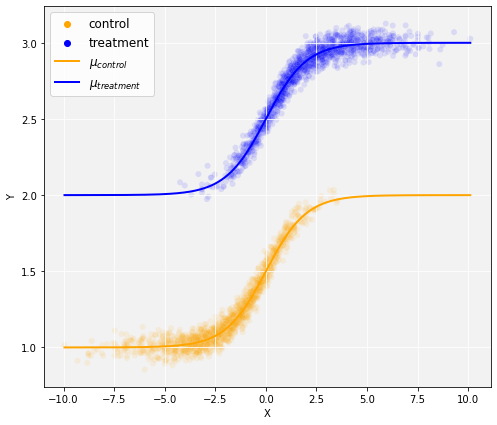

In [2]:
# Generate synthetic data
N = 3000
noise = 0.05
train_test_ratio = 0.7
X = np.random.normal(loc=0.0, scale=3.0, size=N)
T = np.random.binomial(n=1, p=[1/(1 + np.exp(-s)) for s in X])
df = pd.DataFrame(np.stack([X,T], axis=1), columns=['X','T'])
df['Group'] = df.apply(lambda row: 'control' if row['T'] == 0 else 'treatment', axis=1)
df['mu0'] = df.apply(lambda row: 1.0 + 1/(1 + np.exp(-row['X'])), axis=1)
df['mu1'] = df.apply(lambda row: 2.0 + 1/(1 + np.exp(-row['X'])), axis=1)
df['Y0'] = df.apply(lambda row: row['mu0'] + np.random.normal(loc=0.0, scale=noise), axis=1)
df['Y1'] = df.apply(lambda row: row['mu1'] + np.random.normal(loc=0.0, scale=noise), axis=1)
df['Y'] = df.apply(lambda row: row['Y0'] if row['T'] == 0 else row['Y1'], axis=1)

# Visualize data
fig = plt.figure(figsize=(8,7))
ax = plt.gca()
ax.set_facecolor('#F2F2F2')
ax.grid(color='white')
sns.scatterplot(data=df, x='X', y='Y', hue='Group', alpha=0.1, palette={'control':'orange','treatment':'blue'})
ax.plot(sorted(df['X']), [x for _,x in sorted(zip(df['X'],df['mu0']))], color='orange', lw=2, label='$\mu_{control}$')
ax.plot(sorted(df['X']), [x for _,x in sorted(zip(df['X'],df['mu1']))], color='blue', lw=2, label='$\mu_{treatment}$')
ax.legend(fontsize=12)

In [3]:
# Training data
X_train = df['X'][:int(N*train_test_ratio)].to_numpy()[:,None]
T_train = df['T'][:int(N*train_test_ratio)].to_numpy()[:,None]
Y_train = df['Y'][:int(N*train_test_ratio)].to_numpy()[:,None]
mu0_train = df['mu0'][:int(N*train_test_ratio)].to_numpy()[:,None]
mu1_train = df['mu1'][:int(N*train_test_ratio)].to_numpy()[:,None]

# Test data
X_test = df['X'][int(N*train_test_ratio):].to_numpy()[:,None]
T_test = df['T'][int(N*train_test_ratio):].to_numpy()[:,None]
Y_test = df['Y'][int(N*train_test_ratio):].to_numpy()[:,None]
mu0_test = df['mu0'][int(N*train_test_ratio):].to_numpy()[:,None]
mu1_test = df['mu1'][int(N*train_test_ratio):].to_numpy()[:,None]
mu_test = mu1_test - mu0_test

# Initialize dataloaders
data_train = [X_train, T_train]
data_test = [X_test, T_test]
data_generators = create_generators_from_data(data_train, Y_train, data_test, Y_test, train_batch_size=32)

# 2. Define CMDE model

\begin{align*}
&f_1^1, f_2^1, f_3^1 \sim K_1 \\
&f_1^2, f_2^2, f_3^2 \sim K_2 \\
&Y_0(x) = \alpha_1^1 f_1^1(x) + \alpha_3^1 f_3^1(x) + 0 + \alpha_1^2 f_1^2(x) + \alpha_3^2 f_3^2(x) + 0 \\
&Y_1(x) = 0 + \alpha_2^1 f_2^1(x) + \alpha_3^1 f_3^1(x) + 0 + \alpha_2^2 f_2^2(x) + \alpha_3^2 f_3^2(x)
\end{align*}

In [4]:
alpha11, alpha12, alpha13 = 0.0, 0.0, 1.0
num_estimators = 10

ensemble = []
for _ in range(num_estimators):
    f11 = ICK(
        kernel_assignment=['ImplicitDenseNetKernel'],
        kernel_params={
            'ImplicitDenseNetKernel':{
                'input_dim': X_train.shape[1],
                'latent_feature_dim': 2048,
                'num_blocks': 0, 
                'num_layers_per_block': 1, 
                'num_units': 2048, 
                'activation': 'relu'
            }
        }
    )
    f12 = ICK(
        kernel_assignment=['ImplicitDenseNetKernel'],
        kernel_params={
            'ImplicitDenseNetKernel':{
                'input_dim': X_train.shape[1],
                'latent_feature_dim': 2048,
                'num_blocks': 0, 
                'num_layers_per_block': 1, 
                'num_units': 2048, 
                'activation': 'relu'
            }
        }
    )
    f13 = ICK(
        kernel_assignment=['ImplicitDenseNetKernel'],
        kernel_params={
            'ImplicitDenseNetKernel':{
                'input_dim': X_train.shape[1],
                'latent_feature_dim': 2048,
                'num_blocks': 0, 
                'num_layers_per_block': 1, 
                'num_units': 2048, 
                'activation': 'relu'
            }
        }
    )
    f11.kernels[0].reset_parameters_normal(w_std=np.sqrt(0.1),b_std=np.sqrt(0.1))
    f12.kernels[0].reset_parameters_normal(w_std=np.sqrt(0.1),b_std=np.sqrt(0.1))
    f13.kernels[0].reset_parameters_normal(w_std=np.sqrt(0.1),b_std=np.sqrt(0.1))
    baselearner = CMICK(
        control_components=[f11], treatment_components=[f12], shared_components=[f13],
        control_coeffs=[alpha11], treatment_coeffs=[alpha12], shared_coeffs=[alpha13], 
        coeff_trainable=True
    )
    ensemble.append(baselearner)

# 3. Training and evaluation of CMDE model

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
optim = 'sgd'
optim_params = {
    'lr': 5e-5, 
    'momentum': 0.95,
    'weight_decay': 1e-4
}
epochs, patience = 1000, 20
trainer = CMICKEnsembleTrainer(
    model=ensemble,
    data_generators=data_generators,
    optim=optim,
    optim_params=optim_params, 
    model_save_dir=None,
    device=device,
    epochs=epochs,
    patience=patience, 
    treatment_index=1   # The index of "T_train" in "data_train" is 1
)
trainer.train()

PEHE:             0.0173


Text(0.5, 1.0, 'ITE predicted by CMDE')

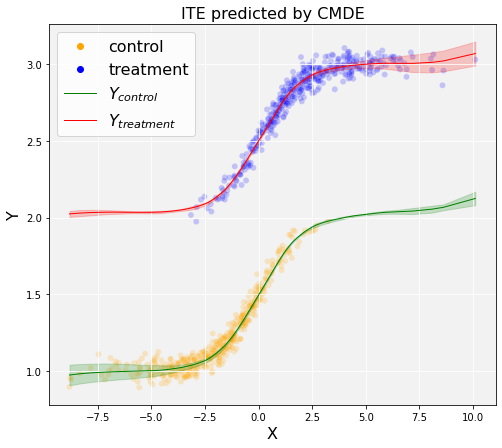

In [6]:
mean_test_pred, std_test_pred, y_test_true = trainer.predict()
mu_test_pred = mean_test_pred[:,1] - mean_test_pred[:,0]

# PEHE
pehe_test_cmde = np.sqrt(np.mean((mu_test_pred - mu_test) ** 2))
print('PEHE:             %.4f' % (pehe_test_cmde))

# Visualize ITE
test_df = df.loc[int(N*train_test_ratio):]
fig = plt.figure(figsize=(8,7))
ax = plt.gca()
ax.set_facecolor('#F2F2F2')
ax.grid(color='white')
sns.scatterplot(data=test_df, x='X', y='Y', hue='Group', alpha=0.2, palette={'control':'orange','treatment':'blue'})
ax.plot(sorted(test_df['X']), [x for _,x in sorted(zip(test_df['X'],mean_test_pred[:,0]))], 
        color='green', lw=1, label='$Y_{control}$')
ax.fill_between(
    sorted(test_df['X']), 
    [x for _,x in sorted(zip(test_df['X'],mean_test_pred[:,0]-2.*std_test_pred[:,0]))],
    [x for _,x in sorted(zip(test_df['X'],mean_test_pred[:,0]+2.*std_test_pred[:,0]))],
    color='green',
    alpha=0.2
)
ax.plot(sorted(test_df['X']), [x for _,x in sorted(zip(test_df['X'],mean_test_pred[:,1]))], 
        color='red', lw=1, label='$Y_{treatment}$')
ax.fill_between(
    sorted(test_df['X']), 
    [x for _,x in sorted(zip(test_df['X'],mean_test_pred[:,1]-2.*std_test_pred[:,1]))],
    [x for _,x in sorted(zip(test_df['X'],mean_test_pred[:,1]+2.*std_test_pred[:,1]))],
    color='red',
    alpha=0.2
)
ax.set_xlabel('X', fontsize=16)
ax.set_ylabel('Y', fontsize=16)
ax.legend(prop={'size':16})
ax.set_title('ITE predicted by CMDE', fontsize=16)

# 4. Apply original CMGP framework on the same dataset

In [7]:
import GPy
from benchmarks.cmgp_modified import CMGP

K0 = GPy.kern.MLP(X_train.shape[1], weight_variance=0.1, bias_variance=0.1, ARD=False)
K1 = GPy.kern.MLP(X_train.shape[1], weight_variance=0.2, bias_variance=0.2, ARD=False)
cmgp_model = CMGP(X_train, T_train, Y_train, kernels=[K0,K1], mode='NSGP', initialize_params=False)
mu0_test_pred, mu1_test_pred, std0_test_pred, std1_test_pred = cmgp_model.predict(X_test.reshape(-1), return_var=True)
mu_test_pred = mu1_test_pred - mu0_test_pred

PEHE:             0.0130


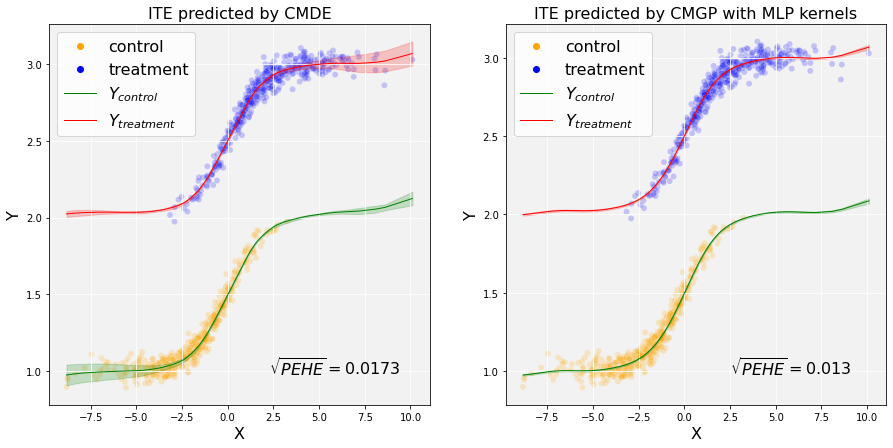

In [8]:
# PEHE
pehe_test_cmgp = np.sqrt(np.mean((mu_test_pred - mu_test) ** 2))
print('PEHE:             %.4f' % (pehe_test_cmgp))

# Visualize ITE
test_df = df.loc[int(N*train_test_ratio):]
fig, axs = plt.subplots(1, 2, figsize=(15,7))

axs[0].set_facecolor('#F2F2F2')
axs[0].grid(color='white')
sns.scatterplot(data=test_df, x='X', y='Y', hue='Group', alpha=0.2, ax=axs[0], 
                palette={'control':'orange','treatment':'blue'})
axs[0].plot(sorted(test_df['X']), [x for _,x in sorted(zip(test_df['X'],mean_test_pred[:,0]))], 
        color='green', lw=1, label='$Y_{control}$')
axs[0].fill_between(
    sorted(test_df['X']), 
    [x for _,x in sorted(zip(test_df['X'],mean_test_pred[:,0]-2.*std_test_pred[:,0]))],
    [x for _,x in sorted(zip(test_df['X'],mean_test_pred[:,0]+2.*std_test_pred[:,0]))],
    color='green',
    alpha=0.2
)
axs[0].plot(sorted(test_df['X']), [x for _,x in sorted(zip(test_df['X'],mean_test_pred[:,1]))], 
        color='red', lw=1, label='$Y_{treatment}$')
axs[0].fill_between(
    sorted(test_df['X']), 
    [x for _,x in sorted(zip(test_df['X'],mean_test_pred[:,1]-2.*std_test_pred[:,1]))],
    [x for _,x in sorted(zip(test_df['X'],mean_test_pred[:,1]+2.*std_test_pred[:,1]))],
    color='red',
    alpha=0.2
)
axs[0].text(0.75, 0.1, '$\sqrt{PEHE} = $'+str(round(pehe_test_cmde,4)), size=16, horizontalalignment='center',
            verticalalignment='center', transform=axs[0].transAxes)
axs[0].set_xlabel('X', fontsize=16)
axs[0].set_ylabel('Y', fontsize=16)
axs[0].legend(prop={'size':16})
axs[0].set_title('ITE predicted by CMDE', fontsize=16)

axs[1].set_facecolor('#F2F2F2')
axs[1].grid(color='white')
sns.scatterplot(data=test_df, x='X', y='Y', hue='Group', alpha=0.2, ax=axs[1], 
                palette={'control':'orange','treatment':'blue'})
axs[1].plot(sorted(test_df['X']), [x for _,x in sorted(zip(test_df['X'],mu0_test_pred.squeeze()))], 
        color='green', lw=1, label='$Y_{control}$')
axs[1].fill_between(
    sorted(test_df['X']), 
    [x for _,x in sorted(zip(test_df['X'],mu0_test_pred.squeeze()-2.*std0_test_pred.squeeze()))],
    [x for _,x in sorted(zip(test_df['X'],mu0_test_pred.squeeze()+2.*std0_test_pred.squeeze()))],
    color='green',
    alpha=0.2
)
axs[1].plot(sorted(test_df['X']), [x for _,x in sorted(zip(test_df['X'],mu1_test_pred.squeeze()))], 
        color='red', lw=1, label='$Y_{treatment}$')
axs[1].fill_between(
    sorted(test_df['X']), 
    [x for _,x in sorted(zip(test_df['X'],mu1_test_pred.squeeze()-2.*std1_test_pred.squeeze()))],
    [x for _,x in sorted(zip(test_df['X'],mu1_test_pred.squeeze()+2.*std1_test_pred.squeeze()))],
    color='red',
    alpha=0.2
)
axs[1].text(0.75, 0.1, '$\sqrt{PEHE} = $'+str(round(pehe_test_cmgp,4)), size=16, horizontalalignment='center',
            verticalalignment='center', transform=axs[1].transAxes)
axs[1].set_xlabel('X', fontsize=16)
axs[1].set_ylabel('Y', fontsize=16)
axs[1].legend(prop={'size':16})
axs[1].set_title('ITE predicted by CMGP with MLP kernels', fontsize=16)

if not os.path.exists('./Figures'):
    os.makedirs('./Figures')
plt.savefig('./Figures/synthetic_data_exp_results.pdf', dpi=300, bbox_inches='tight')